*Best Practices* https://docs.dask.org/en/latest/best-practices.html

# Example Notebook

In [ ]:
!ls /data/common/trade_data

In [2]:
import pandas as pd
import numpy as np
import re
import dask.dataframe as ddf
from math import nan
import panel as pn
import dask
import dask.dataframe as dd
from dask.delayed import delayed
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
from datascroller import scroll

from dask.diagnostics import ProgressBar
ProgressBar().register()

# Customs Data

In [6]:
import_cust_df = dd.read_parquet('/data/common/trade_data/2019/parquet/*.parq', engine='fastparquet', chunksize="100MB")
import_cust_df = import_cust_df.repartition(partition_size="100MB")
import_cust_df.npartitions

[########################################] | 100% Completed |  1min 56.8s


421

In [7]:
import_cust_df_head = import_cust_df.head(10)
import_cust_df_head

[########################################] | 100% Completed |  6.0s


,System Identity Id,Estimate Arrival Date,Actual Arrival Date,Bill of Lading,Master Bill of Lading,Bill Type Code,Carrier SASC Code,Vessel Country Code,Vessel Code,Vessel Name,...,Raw Notify Party Addr4,Raw Notify Party Addr Others,Product Desc,Marks & Numbers,HS Code,HS Code Sure Level,CIF,Indicator of true supplier,Indicator of true buyer,END
0,6003201901310000026837,20190106,20190108,APLULMY0101580,None,R,"APLU, AMERICAN PRESIDENT LINES LTD",SG,9462017,APL SOUTHAMPTON,...,None,None,"SOUNDBAR 500,AST,BLACK - 612 UNITS SOUNDBAR 70...",TOTAL 40 PACKAGES<br/>,321511,5,0.0,Y,Y,END
1,6003201901310000026875,20181230,20190105,UASI7796618863,YMLUW232286499,H,UASI,PA,9395159,HAMBURG BRIDGE,...,None,None,TOASTMASTER ELECTRIC GIDDLE 1020 BLACK<br/>,NM<br/>,321511,5,0.0,Y,Y,END
2,6003201901310000026925,20181230,20190114,DSVFCO30000677,YMLUE510009910,H,DSVF,MH,9635676,ALEXANDRA,...,None,None,6 PACKAGES ROSEWOOD VENEERS - 3000<br/>,TAYLOR/GMD EL CAJON CERTIFICATE NO : 249/WCC B...,870323,5,0.0,Y,Y,END
3,6003201901310000027021,20190102,20190105,EGLV002800582698,None,R,"EGLV, EAGLE VAN LINES INC",GB,9595436,EVER LAMBENT,...,None,None,WILLOUGHBY TRAY LARGE C-2 WALNUT WOODEN FURNIT...,SKU. SKU. VENDOR NO. 26997 NO. 20 SANCENG LANE...,442199,8,0.0,Y,Y,END
4,6003201901310000027128,20190105,20190110,SVDL2603217436,APLUAZT0101648,H,"SVDL, SAVINO DEL BENE S P A",LR,TOLTEN,TOLTEN,...,None,MILANO MI 20126 IT,CABLES COMPOUND<br/>,PRYSMIAN CABLES AND SYSTEMS USA LLC<br/>,901190,5,0.0,Y,Y,END
5,6003201901310000027136,20190105,20190110,SVDL2603217442,APLUAZT0101648,H,"SVDL, SAVINO DEL BENE S P A",LR,TOLTEN,TOLTEN,...,None,MILANO MI 20126 IT,CABLES COMPOUND<br/>,PRYSMIAN CABLES AND SYSTEMS USA LLC<br/>,901190,5,0.0,Y,Y,END
6,6003201901310000027144,20190105,20190110,SVDL2603218899,APLUAZT0101648,H,"SVDL, SAVINO DEL BENE S P A",LR,TOLTEN,TOLTEN,...,None,MILANO MI 20126 IT,CABLES COMPOUND<br/>,PRYSMIAN CABLES AND SYSTEMS USA LLC<br/>,901190,5,0.0,Y,Y,END
7,6003201901310000027152,20190105,20190110,SVDL2603218010,APLUAZT0101648,H,"SVDL, SAVINO DEL BENE S P A",LR,TOLTEN,TOLTEN,...,None,MILANO MI 20126 IT,CABLES COMPOUND<br/>,PRYSMIAN CABLES AND SYSTEMS USA LLC<br/>,901190,5,0.0,Y,Y,END
8,6003201901310000027160,20190105,20190110,SVDL2603218078,APLUAZT0101648,H,"SVDL, SAVINO DEL BENE S P A",LR,TOLTEN,TOLTEN,...,None,MILANO MI 20126 IT,CABLES COMPOUND<br/>,PRYSMIAN CABLES AND SYSTEMS USA LLC<br/>,901190,5,0.0,Y,Y,END
9,6003201901310000027168,20190105,20190110,SVDL2603218888,APLUAZT0101648,H,"SVDL, SAVINO DEL BENE S P A",LR,TOLTEN,TOLTEN,...,None,MILANO MI 20126 IT,CABLES COMPOUND<br/>,PRYSMIAN CABLES AND SYSTEMS USA LLC<br/>,901190,5,0.0,Y,Y,END


In [8]:
type(import_cust_df_head)

pandas.core.frame.DataFrame

In [9]:
customs_col_list = import_cust_df.columns
customs_col_list

Index(['System Identity Id', 'Estimate Arrival Date', 'Actual Arrival Date',
       'Bill of Lading', 'Master Bill of Lading', 'Bill Type Code',
       'Carrier SASC Code', 'Vessel Country Code', 'Vessel Code',
       'Vessel Name', 'Voyage', 'Inbond Type', 'Manifest No',
       'Mode of Transportation', 'Loading Port', 'Last Vist Foreign Port',
       'US Clearing District', 'Unloading Port', 'Place of Receipt', 'Country',
       'Country Sure Level', 'Weight in KG', 'Weight', 'Weight Unit', 'TEU',
       'Quantity', 'Quantity Unit', 'Measure in CM', 'Measure', 'Measure Unit',
       'Container Id', 'Container Size', 'Container Type',
       'Container Desc Code', 'Container Load Status',
       'Container Type of Service', 'Shipper Name', 'Shipper Address ',
       'Raw Shipper Name', 'Raw Shipper Addr1', 'Raw Shipper Addr2',
       'Raw Shipper Addr3', 'Raw Shipper Addr4', 'Raw Shipper Addr Others',
       'Consignee Name', 'Consignee Address ', 'Raw Consignee Name',
       'Raw Con

In [10]:
print(f'2019 customs data has {len(import_cust_df.index):,} records.')

[########################################] | 100% Completed |  1min  4.0s
2019 customs data has 12,451,358 records.


In [11]:
import_cust_df_head.loc[0, ["HS Code", "HS Code Sure Level", 'Product Desc']]

HS Code                                                          321511
HS Code Sure Level                                                    5
Product Desc          SOUNDBAR 500,AST,BLACK - 612 UNITS SOUNDBAR 70...
Name: 0, dtype: object

Let's look at the HS codes we have and their distribution

In [10]:
col_types = import_cust_df.dtypes
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(col_types)

System Identity Id               object
Estimate Arrival Date             int64
Actual Arrival Date               int64
Bill of Lading                   object
Master Bill of Lading            object
Bill Type Code                   object
Carrier SASC Code                object
Vessel Country Code              object
Vessel Code                      object
Vessel Name                      object
Voyage                           object
Inbond Type                     float64
Manifest No                       int64
Mode of Transportation            int64
Loading Port                     object
Last Vist Foreign Port           object
US Clearing District             object
Unloading Port                   object
Place of Receipt                 object
Country                          object
Country Sure Level                int64
Weight in KG                    float64
Weight                          float64
Weight Unit                      object
TEU                             float64


In [11]:
import_cust_df['HS Code'] = import_cust_df['HS Code'].astype(int)

In [ ]:
#Check for nulls in 'HS Code'
#import_cust_df['HS Code'].isnull().count().compute()


In [13]:
import_cust_df = import_cust_df.dropna(subset='HS Code').compute()
len(import_cust_df)

ValueError: Metadata inference failed in `dropna`.

You have supplied a custom function and Dask is unable to 
determine the type of output that that function returns. 

To resolve this please provide a meta= keyword.
The docstring of the Dask function you ran should have more information.

Original error is below:
------------------------
TypeError("Index(...) must be called with a collection of some kind, 'HS Code' was passed")

Traceback:
---------
  File "/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py", line 172, in raise_on_meta_error
    yield
  File "/usr/local/lib/python3.8/dist-packages/dask/dataframe/core.py", line 5055, in _emulate
    return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))
  File "/usr/local/lib/python3.8/dist-packages/dask/utils.py", line 894, in __call__
    return getattr(obj, self.method)(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py", line 5156, in dropna
    indices = ax.get_indexer_for(subset)
  File "/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py", line 4960, in get_indexer_for
    return self.get_indexer(target, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py", line 3147, in get_indexer
    target = ensure_index(target)
  File "/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py", line 5917, in ensure_index
    return Index(index_like)
  File "/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py", line 372, in __new__
    raise cls._scalar_data_error(data)


In [3]:
# Look at the HS codes
HS_codes = pd.read_csv('/data/common/trade_data/HS/hts_lookup_2019_v1.csv', index_col=0).astype({'hs': 'str'})


In [4]:
HS_codes.head(10)

,hs,desc
0,10121,"Live horses, asses, mules and hinnies, Horses,..."
1,10129,"Live horses, asses, mules and hinnies, Horses,..."
2,10130,"Live horses, asses, mules and hinnies, Asses, ..."
3,10190,"Live horses, asses, mules and hinnies, Other, ..."
4,10221,"Live bovine animals, Cattle, Purebred breeding..."
5,10229,"Live bovine animals, Cattle, Other, Cows impor..."
6,10231,"Live bovine animals, Buffalo, Purebred breedin..."
7,10239,"Live bovine animals, Buffalo, Other, Bison, We..."
8,10290,"Live bovine animals, Other, Other, Other, Weig..."
9,10310,"Live swine, Purebred breeding animals"


In [5]:
len(HS_codes)

5520

In [53]:
hs_codes = import_cust_df.groupby(['HS Code']).count().compute()

[                                        ] | 0% Completed | 30.9s
[                                        ] | 0% Completed | 31.8s
[                                        ] | 0% Completed | 32.0s


TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

What is 'HS Code Sure Level'?

# BOL Data

### Read single parquet

In [51]:
df_2020 = dd.read_parquet('/data/common/trade_data/raw_import_2020.parq')
df_2019 = dd.read_parquet('/data/common/trade_data/raw_import_2019.parq')
df_2018 = dd.read_parquet('/data/common/trade_data/raw_import_2018.parq')
df_2017 = dd.read_parquet('/data/common/trade_data/raw_import_2017.parq')
df_2015_16 = dd.read_parquet('/data/common/trade_data/raw_import_20152016.parq')

In [52]:
df_2020.columns

Index(['Unnamed: 0', ' Booking No ', ' B/L No ', ' Shipper ',
       ' Shipper Address ', ' Consignee ', ' Consignee Address ', ' TEU ',
       ' FEU ', ' Trunk VVD ', ' Vessel Name', ' POR ', ' POL(Booking) ',
       ' POD(Booking) ', ' DEL ', ' WGT(KGS) ', ' MEA(CBM) ', ' PKG ',
       ' PKG Unit', ' REP CMDT', ' CMDT Code', ' CMDT',
       ' Customs Description ', ' Freight Term', ' Forward Name ',
       ' Notify Name ', ' Notify Address ', ' Also Notify Name ',
       ' Export Name ', '  Trunk POL', '  Trunk POD',
       ' Booking Contact Phone Number ', ' Booking Contact E-Mail ',
       ' SI Contact Phone Number ', ' SI Contact E-Mail ', '  Sailing DT ',
       ' REV.WEEK ', ' Activity Teu ', ' Activity Feu ', ' Mty P/up CY '],
      dtype='object')

In [53]:
col_list = df_2020.columns

In [54]:
print(f'2020 data has {len(df_2020.index):,} records.')
print(f'2019 data has {len(df_2019.index):,} records.')
print(f'2018 data has {len(df_2018.index):,} records.')
print(f'2017 data has {len(df_2017.index):,} records.')
print(f'2015 & 2016 data has {len(df_2015_16.index):,} records.')

[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.4s
2020 data has 691,302 records.
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.3s
2019 data has 690,878 records.
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.4s
2018 data has 400,930 records.
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s
2017 data has 401,071 records.
[########################################] | 100% Completed 

In [55]:
df_2020.head()

[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.2s


,Unnamed: 0,Booking No,B/L No,Shipper,Shipper Address,Consignee,Consignee Address,TEU,FEU,Trunk VVD,...,Trunk POD,Booking Contact Phone Number,Booking Contact E-Mail,SI Contact Phone Number,SI Contact E-Mail,Sailing DT,REV.WEEK,Activity Teu,Activity Feu,Mty P/up CY
0,0,FOC202323700,FOC202323700W,"MAGUS INDUSTRY CO., LTD.","6F,#300,JUI-KUANG RD.,NEIHU DIST,TA\nIPEI,TAIW...",EUROMARKET DESIGNS INC.,"1250 TECHNY ROAD,\nNORTHBROOK, IL 60062 U.S.A....",1.0,0.0,CEUR1545E,...,LGBSC,86-0591-87821845,nicho@fjstarsea.com,059187821845,nicho@fjstarsea.com,2020-01-01 03:00:00,NaN,1,0,CNFOCJC
1,1,SZP2G9219200,SZP2G9219200,"OEC LOGISTICS (QINGDAO) CO., LTD. SHENZHEN B...","ROOM 12A01-02, NO.4018, ANLIAN \nPLAZA, JI...",OEC FREIGHT (NY) INC.,ONE CROSS ISLAND PLAZA 133-33 \nBROOKVILL...,0.0,5.0,CHLS1563E,...,LGBSC,86-755-33391828,ops.szn@oecgroup.com.cn,None,None,2020-01-01 03:00:00,NaN,0,5,CNJIAY1
2,2,TATK21239200,TATK21239200W,SAMSUNG ELECTRONICS (SHANDONG) DIGITAL PRINTIN...,(SSDP) SAMSUNG ROAD WEIHAI\nHI-TECH.IDZ WEIHAI...,SAMSUNG ELECTRONIC AMERICA AMERICAN DISTRIBUTI...,"4921 DIRECTORS PLACE SUITE 200\nSAN DIEGO, CA ...",0.0,8.0,HYKT1555E,...,CHISC,None,None,053285732151,sandyzhou@bondex.com.cn,2020-01-01 03:00:00,NaN,0,8,CNWEIY0
3,3,TATK21266100,TATK21266100W,SAMSUNG ELECTRONICS (SHANDONG) DIGITAL PRINTIN...,(SSDP) SAMSUNG ROAD WEIHAI\nHI-TECH.IDZ WEIHAI...,SAMSUNG ELECTRONICS AMERICA. AMERICAN DISTRIBU...,"12014 EASTGATE BLVD.,MT JULIET,\nTENNESSEE 371...",0.0,3.0,HYKT1555E,...,ATLSC,None,None,053285732151,sandyzhou@bondex.com.cn,2020-01-01 03:00:00,NaN,0,3,CNWEIY0
4,4,TATK21556600,TATK21556600W,SAMSUNG ELECTRONICS (SHANDONG) DIGITAL PRINTIN...,SAMSUNG ROAD WEIHAI\nHI-TECH.IDZ WEIHAI CITY \...,SAMSUNG ELECTRONIC AMERICA AMERICAN DISTRIBUTI...,"4921 DIRECTORS PLACE SUITE 200\nSAN DIEGO, CA ...",0.0,5.0,HYKT1555E,...,LGBSC,None,None,053285732151,sandyzhou@bondex.com.cn,2020-01-01 03:00:00,NaN,0,5,CNWEIY0


### Read everything 

In [114]:
import_df = dd.read_parquet('/data/common/trade_data/*.parq', engine='fastparquet')

In [115]:
len(import_df)

[########################################] | 100% Completed |  8.1s
[########################################] | 100% Completed |  8.1s
[########################################] | 100% Completed |  8.2s
[########################################] | 100% Completed |  8.2s
[########################################] | 100% Completed |  8.3s


2875681

In [116]:
import_df['date'] = dd.to_datetime(import_df['  Sailing DT '])
#import_df['date'] = import_df['date'].dt.date

In [121]:
import_df[['date']].head(10)

[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.8s


,date
0,2017-01-05 16:45:00
1,2017-01-05 16:45:00
2,2017-01-05 16:45:00
3,2017-01-05 16:45:00
4,2017-01-05 16:45:00
5,2017-01-05 16:45:00
6,2017-01-05 16:45:00
7,2017-01-05 16:45:00
8,2017-01-05 16:45:00
9,2017-01-05 16:45:00


In [122]:
import_df['year'] = import_df['date'].dt.year

In [123]:
import_df[import_df.year == 2017].head(2)

[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.9s


,Unnamed: 0,Booking No,B/L No,Shipper,Shipper Address,Consignee,Consignee Address,TEU,FEU,Trunk VVD,...,Booking Contact E-Mail,SI Contact Phone Number,SI Contact E-Mail,Sailing DT,REV.WEEK,Activity Teu,Activity Feu,Mty P/up CY,date,year
0,0,BKK717427400,BKK717427400,THAI UNION FROZEN PRODUCTS PUBLIC COMPANY LIMITED,"979/12,M FLOOR,SM TOWER\nPHAHOLYOTHIN ROAD,SAM...","TO THE ORDER OF BANK OF AMERICA,N.A.","450 B STREET,SUITE 430\nSAN DIEGO,CA 92101-890...",0.0,5.0,ANTY0003W,...,piyaporn_sa@thaiunion.co.th,22980024,onuma_ap@thaiunion.co.th,2017-01-05 16:45:00,NaN,0,5,THLKGY1,2017-01-05 16:45:00,2017
1,1,BKK717427401,BKK717427401,THAI UNION FROZEN PRODUCTS PUBLIC COMPANY LIMITED,"979/12,M FLOOR,SM TOWER\nPHAHOLYOTHIN ROAD,SAM...","TO THE ORDER OF BANK OF AMERICA,N.A.","450 B STREET,SUITE 430\nSAN DIEGO,CA 92101-890...",0.0,5.0,ANTY0003W,...,piyaporn_sa@thaiunion.co.th,22980024,onuma_ap@thaiunion.co.th,2017-01-05 16:45:00,NaN,0,5,THLKGY1,2017-01-05 16:45:00,2017


https://blog.dask.org/2019/10/08/df-groupby

In [14]:
s1 = import_df.groupby(['year']).year.count().compute() # Do not call compute always. It will kill the notebook

[########################################] | 100% Completed |  8.1s


In [15]:
type(s1)

pandas.core.series.Series

In [16]:
df = pd.DataFrame({'year':s1.index, 'values':s1.values}).sort_values("year").reset_index(drop=True)
df

,year,values
0,2015,411648
1,2016,279852
2,2017,401071
3,2018,400930
4,2019,690878
5,2020,691302


In [17]:
df.T

,0,1,2,3,4,5
year,2015,2016,2017,2018,2019,2020
values,411648,279852,401071,400930,690878,691302


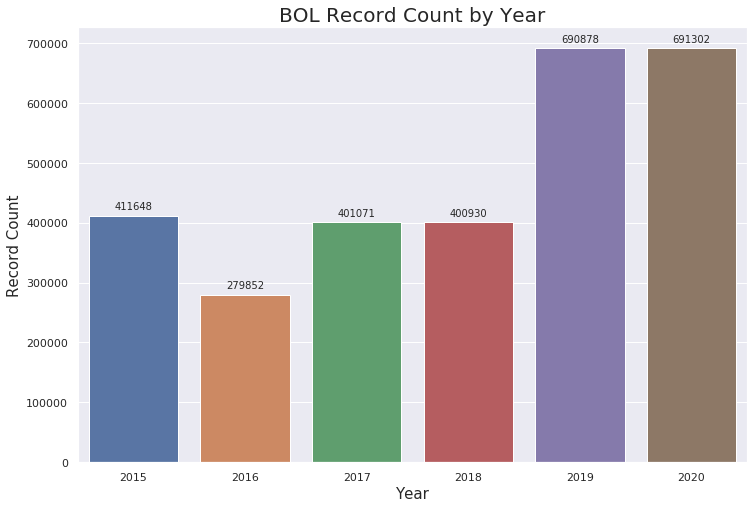

In [18]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.barplot(data=df, x="year", y="values")
ax.axes.set_title('BOL Record Count by Year', fontsize = 20)
ax.set_xlabel('Year', fontsize = 15)
ax.set_ylabel('Record Count', fontsize = 15)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9),
                   fontsize = 10,
                   textcoords = 'offset points')


In [19]:
import_df[import_df.year == 2017][[' Trunk VVD ', ' Vessel Name', ' POR ']].to_parquet('trade_data_test_2017', storage_options={"has_nulls": True})

[########################################] | 100% Completed |  8.7s


In [18]:
!ls trade_data_test_2017

_common_metadata  _metadata  part.0.parquet


In [19]:
reload_df = dd.read_parquet('trade_data_test_2017', engine='fastparquet')

In [20]:
reload_df.head()

[########################################] | 100% Completed |  0.3s


,Trunk VVD,Vessel Name,POR
index,,,
0,ANTY0003W,AL ABDALI,THLKG
1,ANTY0003W,AL ABDALI,THLKG
2,ANTY0003W,AL ABDALI,THLKG
3,CNAG0061E,COSCO AQABA,THLCH
4,COHA0022E,COSCO AQABA,THLKG


## Let's explore the shippers and orderers (Shipper and Consignee).

In [124]:
import_df.head()

[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.6s


,Unnamed: 0,Booking No,B/L No,Shipper,Shipper Address,Consignee,Consignee Address,TEU,FEU,Trunk VVD,...,Booking Contact E-Mail,SI Contact Phone Number,SI Contact E-Mail,Sailing DT,REV.WEEK,Activity Teu,Activity Feu,Mty P/up CY,date,year
0,0,BKK717427400,BKK717427400,THAI UNION FROZEN PRODUCTS PUBLIC COMPANY LIMITED,"979/12,M FLOOR,SM TOWER\nPHAHOLYOTHIN ROAD,SAM...","TO THE ORDER OF BANK OF AMERICA,N.A.","450 B STREET,SUITE 430\nSAN DIEGO,CA 92101-890...",0.0,5.0,ANTY0003W,...,piyaporn_sa@thaiunion.co.th,22980024,onuma_ap@thaiunion.co.th,2017-01-05 16:45:00,NaN,0,5,THLKGY1,2017-01-05 16:45:00,2017
1,1,BKK717427401,BKK717427401,THAI UNION FROZEN PRODUCTS PUBLIC COMPANY LIMITED,"979/12,M FLOOR,SM TOWER\nPHAHOLYOTHIN ROAD,SAM...","TO THE ORDER OF BANK OF AMERICA,N.A.","450 B STREET,SUITE 430\nSAN DIEGO,CA 92101-890...",0.0,5.0,ANTY0003W,...,piyaporn_sa@thaiunion.co.th,22980024,onuma_ap@thaiunion.co.th,2017-01-05 16:45:00,NaN,0,5,THLKGY1,2017-01-05 16:45:00,2017
2,2,BKK717427402,BKK717427402,THAI UNION FROZEN PRODUCTS PUBLIC COMPANY LIMITED,"979/12,M FLOOR,SM TOWER\nPHAHOLYOTHIN ROAD,SAM...","TO THE ORDER OF BANK OF AMERICA,N.A.","450 B STREET,SUITE 430\nSAN DIEGO,CA 92101-890...",0.0,5.0,ANTY0003W,...,piyaporn_sa@thaiunion.co.th,22980024,onuma_ap@thaiunion.co.th,2017-01-05 16:45:00,NaN,0,5,THLKGY1,2017-01-05 16:45:00,2017
3,3,BKK718896200,BKK718896200,"OKEANOS FOOD CO.,LTD.","103 NONSEE RD.,CHONGNONSEE,\nYANNAWA,BANGKOK 1...",TO ORDER OF BANK OF AMERICA N.A,"450 B STREET, SUITE 430\nSAN DIEGO,CA 92101 U....",0.0,1.0,CNAG0061E,...,juthamard@pakfood.co.th; speeddeetrans_848@hot...,22951991360,ratchadaporn@pakfood.co.th,2017-01-05 16:45:00,NaN,0,1,THLKGY1,2017-01-05 16:45:00,2017
4,4,BKK716997200,BKK716997200W,"CHIANGMAI FROZEN FOODS PUBLIC CO.,LTD.","149/34 SOI ANGLO PLAZA,\nSURAWONGSE ROAD,BANGK...",NEW YORK MUTUAL TRADING INC.,"77 METRO WAY,SECAUCUS,NJ 07094\nTEL:(201)933-9...",0.0,1.0,COHA0022E,...,wachiraporn@cmfrozen.com,26340061,wachiraporn@cmfrozen.com,2017-01-05 16:45:00,NaN,0,1,THLKGY1,2017-01-05 16:45:00,2017


In [125]:
# Column names have leading and trailing spaces that we have to get rid of
import_df_clean = import_df.rename(columns=lambda x: x.strip())
import_df_clean.head()

[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.8s


,Unnamed: 0,Booking No,B/L No,Shipper,Shipper Address,Consignee,Consignee Address,TEU,FEU,Trunk VVD,...,Booking Contact E-Mail,SI Contact Phone Number,SI Contact E-Mail,Sailing DT,REV.WEEK,Activity Teu,Activity Feu,Mty P/up CY,date,year
0,0,BKK717427400,BKK717427400,THAI UNION FROZEN PRODUCTS PUBLIC COMPANY LIMITED,"979/12,M FLOOR,SM TOWER\nPHAHOLYOTHIN ROAD,SAM...","TO THE ORDER OF BANK OF AMERICA,N.A.","450 B STREET,SUITE 430\nSAN DIEGO,CA 92101-890...",0.0,5.0,ANTY0003W,...,piyaporn_sa@thaiunion.co.th,22980024,onuma_ap@thaiunion.co.th,2017-01-05 16:45:00,NaN,0,5,THLKGY1,2017-01-05 16:45:00,2017
1,1,BKK717427401,BKK717427401,THAI UNION FROZEN PRODUCTS PUBLIC COMPANY LIMITED,"979/12,M FLOOR,SM TOWER\nPHAHOLYOTHIN ROAD,SAM...","TO THE ORDER OF BANK OF AMERICA,N.A.","450 B STREET,SUITE 430\nSAN DIEGO,CA 92101-890...",0.0,5.0,ANTY0003W,...,piyaporn_sa@thaiunion.co.th,22980024,onuma_ap@thaiunion.co.th,2017-01-05 16:45:00,NaN,0,5,THLKGY1,2017-01-05 16:45:00,2017
2,2,BKK717427402,BKK717427402,THAI UNION FROZEN PRODUCTS PUBLIC COMPANY LIMITED,"979/12,M FLOOR,SM TOWER\nPHAHOLYOTHIN ROAD,SAM...","TO THE ORDER OF BANK OF AMERICA,N.A.","450 B STREET,SUITE 430\nSAN DIEGO,CA 92101-890...",0.0,5.0,ANTY0003W,...,piyaporn_sa@thaiunion.co.th,22980024,onuma_ap@thaiunion.co.th,2017-01-05 16:45:00,NaN,0,5,THLKGY1,2017-01-05 16:45:00,2017
3,3,BKK718896200,BKK718896200,"OKEANOS FOOD CO.,LTD.","103 NONSEE RD.,CHONGNONSEE,\nYANNAWA,BANGKOK 1...",TO ORDER OF BANK OF AMERICA N.A,"450 B STREET, SUITE 430\nSAN DIEGO,CA 92101 U....",0.0,1.0,CNAG0061E,...,juthamard@pakfood.co.th; speeddeetrans_848@hot...,22951991360,ratchadaporn@pakfood.co.th,2017-01-05 16:45:00,NaN,0,1,THLKGY1,2017-01-05 16:45:00,2017
4,4,BKK716997200,BKK716997200W,"CHIANGMAI FROZEN FOODS PUBLIC CO.,LTD.","149/34 SOI ANGLO PLAZA,\nSURAWONGSE ROAD,BANGK...",NEW YORK MUTUAL TRADING INC.,"77 METRO WAY,SECAUCUS,NJ 07094\nTEL:(201)933-9...",0.0,1.0,COHA0022E,...,wachiraporn@cmfrozen.com,26340061,wachiraporn@cmfrozen.com,2017-01-05 16:45:00,NaN,0,1,THLKGY1,2017-01-05 16:45:00,2017


In [126]:
s2 = import_df_clean.groupby(['year']).Shipper.nunique().compute() # Do not call compute always. It will kill the notebook

[########################################] | 100% Completed | 10.0s
[########################################] | 100% Completed | 10.1s
[########################################] | 100% Completed | 10.2s
[########################################] | 100% Completed | 10.3s
[########################################] | 100% Completed | 10.4s


In [130]:
s2all = import_df_clean.Shipper.nunique().compute() # Do not call compute always. It will kill the notebook
s2all

[########################################] | 100% Completed |  9.6s
[########################################] | 100% Completed |  9.7s
[########################################] | 100% Completed |  9.8s
[########################################] | 100% Completed |  9.9s
[########################################] | 100% Completed | 10.0s


48317

In [23]:
df2 = pd.DataFrame({'year':s2.index, 'values':s2.values}).sort_values("year").reset_index(drop=True)
df2

,year,values
0,2015,33492
1,2016,26989
2,2017,32663
3,2018,32661
4,2019,47894
5,2020,47893


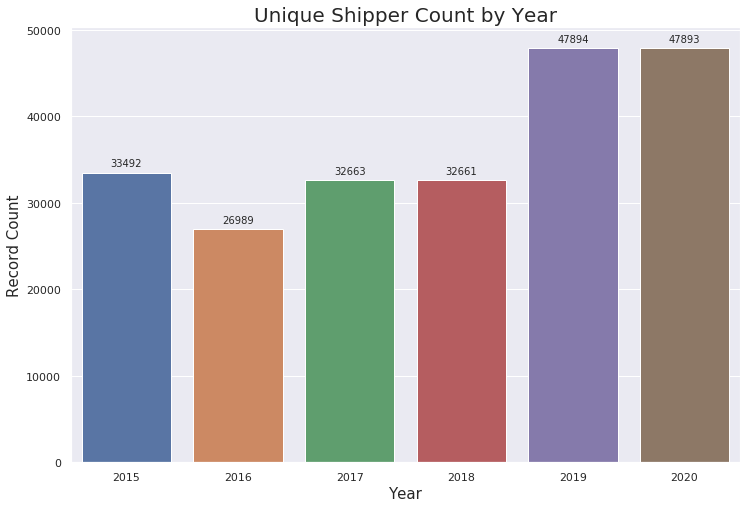

In [24]:
#plot the number of unique shippers by year
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.barplot(data=df2, x="year", y="values")
ax.axes.set_title('Unique Shipper Count by Year', fontsize = 20)
ax.set_xlabel('Year', fontsize = 15)
ax.set_ylabel('Record Count', fontsize = 15)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9),
                   fontsize = 10,
                   textcoords = 'offset points')

In [25]:
s3 = import_df_clean.groupby(['year']).Consignee.nunique().compute() # Do not call compute always. It will kill the notebook
df3 = pd.DataFrame({'year':s3.index, 'values':s3.values}).sort_values("year").reset_index(drop=True)
df3

[########################################] | 100% Completed |  9.5s


,year,values
0,2015,20376
1,2016,16430
2,2017,19718
3,2018,19712
4,2019,29277
5,2020,29278


In [131]:
s3all = import_df_clean.Consignee.nunique().compute()
s3all

[########################################] | 100% Completed |  9.4s
[########################################] | 100% Completed |  9.5s
[########################################] | 100% Completed |  9.6s
[########################################] | 100% Completed |  9.7s
[########################################] | 100% Completed |  9.8s


29365

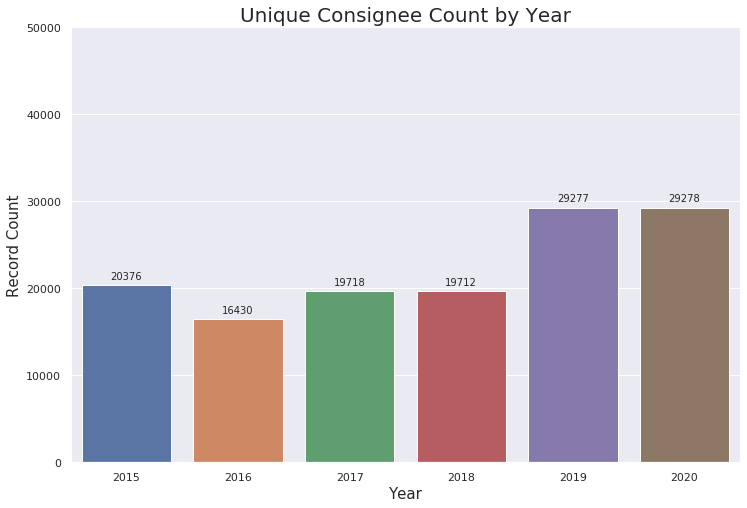

In [132]:
#plot the number of unique consingees by year
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.barplot(data=df3, x="year", y="values")
ax.axes.set_title('Unique Consignee Count by Year', fontsize = 20)
ax.set_xlabel('Year', fontsize = 15)
ax.set_ylabel('Record Count', fontsize = 15)
ax.set(ylim=(0,50000))
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9),
                   fontsize = 10,
                   textcoords = 'offset points')

### What is being shipped?

In [62]:
# Let's see what kind of info is in the relevant fields

import_df_clean[['PKG', 'PKG Unit', 'REP CMDT', 'CMDT Code', 'CMDT', 'Customs Description']].head(20)


[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.8s


,PKG,PKG Unit,REP CMDT,CMDT Code,CMDT,Customs Description
0,19800,BG,300,30015,"FROZEN FISH, NOS",FROZEN PRECOOKED SKIPJACK LOINS WITH AVAILABLE...
1,19800,BG,300,30015,"FROZEN FISH, NOS",FROZEN PRECOOKED SKIPJACK LOINS WITH AVAILABLE...
2,19800,BG,300,30015,"FROZEN FISH, NOS",FROZEN PRECOOKED SKIPJACK LOINS WITH AVAILABLE...
3,3400,CT,1600,160001,"FROZEN SEAFOOD, NOS",FROZEN SHRIMP
4,2088,CT,700,70003,"VEGETABLES, REEFER, NOS;",FROZEN BOILED SOY BEANS
5,790,CT,1600,160001,"FROZEN SEAFOOD, NOS",FROZEN SHRIMP
6,780,CT,1600,160001,"FROZEN SEAFOOD, NOS",FROZEN SHRIMP
7,680,CT,1600,160001,"FROZEN SEAFOOD, NOS",FROZEN CALAMARI RINGS
8,200,CT,7000,701113,"HOUSEWARE ITEMS, NOS;",DIXON BAMBOO HAMPER WITH LINER
9,84,ST,8500,853934,"ELECTRONIC GOODS AND PARTS, NOS;",ELECTRIC OVEN


In [63]:
s4 = import_df_clean.groupby(['CMDT Code'])["B/L No"].count().compute() # Do not call compute always. It will kill the notebook


[########################################] | 100% Completed |  9.4s
[########################################] | 100% Completed |  9.5s
[########################################] | 100% Completed |  9.6s


In [64]:
# How many different commodity codes?

import_df_clean['CMDT Code'].nunique().compute()

[########################################] | 100% Completed |  9.4s
[########################################] | 100% Completed |  9.5s
[########################################] | 100% Completed |  9.6s


2282

In [65]:
# How many different REP CMDT codes?

import_df_clean['REP CMDT'].nunique().compute()

[########################################] | 100% Completed |  9.3s
[########################################] | 100% Completed |  9.4s
[########################################] | 100% Completed |  9.5s


121

In [72]:
codes = dask.delayed(pd.read_excel)('/data/common/trade_data/manifestDB - CMDT Codes directory.xlsx')

commodities_master = dd.from_delayed(codes)
commodities_master = commodities_master.rename(columns=lambda x: x.strip())

[                                        ] | 0% Completed |  0.2s

/usr/local/lib/python3.8/dist-packages/dask/core.py:121: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s


In [105]:
commodities_master.head(10)

[                                        ] | 0% Completed |  0.2s

/usr/local/lib/python3.8/dist-packages/dask/core.py:121: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s


,REP CMDT,CMDT Code,CMDT - Commodity
0,0,0,"FAK OR CARGO, NOS"
1,0,1,"REFRIGERATED AND TEMPERATURE CONTROLLED CARGO,..."
2,0,2,"FREIGHT ALL KINDS, FAK"
3,0,3,"CARGO IN REFRIGERATION, NOS"
4,0,4,"CONSOLIDATED OR MIXED LOADS OF COMMODITIES,NOS..."
5,0,5,STRAIGHT OR MIXED COMMODITIES NOS (BUT EXCLUDI...
6,0,7,"FREIGHT ALL KINDS(SINGLE COMMODITY LOAD, STRAI..."
7,0,8,"FREIGHT ALL KINDS(EXCLUDING GARMENTS, NOS)"
8,0,9,STRAIGHT OR MIXED LOADS OF COMMODITIES NOS INC...
9,0,12,"GDSM EXCLUDING TEXILE, NON-HAZARDOUS, IN MIXED..."


In [74]:
# How many total CMDT Codes in the master file?
commodities_master['CMDT Code'].nunique().compute()

[                                        ] | 0% Completed |  0.2s

/usr/local/lib/python3.8/dist-packages/dask/core.py:121: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s


4441

In [75]:
# How many total REP CMDT Codes in the master file?
commodities_master['REP CMDT'].nunique().compute()

[                                        ] | 0% Completed |  0.2s

/usr/local/lib/python3.8/dist-packages/dask/core.py:121: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s


126

In [87]:
pct_cmdt = import_df_clean['CMDT Code'].nunique().compute()/commodities_master['CMDT Code'].nunique().compute()
pct_rpt = import_df_clean['REP CMDT'].nunique().compute()/commodities_master['REP CMDT'].nunique().compute()

print('%.2f percent of the total CMDT Codes are present in the sample data.' %(pct_cmdt*100))
print('%.2f percent of the total RPT CMDT Codes are present in the sample data.' %(pct_rpt*100))

[########################################] | 100% Completed |  9.3s
[########################################] | 100% Completed |  9.4s
[########################################] | 100% Completed |  9.5s
[########################################] | 100% Completed |  9.6s
[                                        ] | 0% Completed |  0.1s

/usr/local/lib/python3.8/dist-packages/dask/core.py:121: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  9.3s
[########################################] | 100% Completed |  9.4s
[########################################] | 100% Completed |  9.5s
[########################################] | 100% Completed |  9.6s
[                                        ] | 0% Completed |  0.2s

/usr/local/lib/python3.8/dist-packages/dask/core.py:121: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
51.38 percent of the total CMDT Codes are present in the sample data.
96.03 percent of the total RPT CMDT Codes are present in the sample data.


In [31]:
df4 = pd.DataFrame({'CMDT Code':s4.index, 'B/L_No_count':s4.values}).sort_values("B/L_No_count").reset_index(drop=True)
df4

,CMDT Code,B/L_No_count
0,980028.0,3
1,520008.0,3
2,530700.0,3
3,531001.0,3
4,550002.0,3
...,...,...
2277,540009.0,97433
2278,4.0,98146
2279,853934.0,169778
2280,25.0,183598


In [32]:
df4.tail(20)

,CMDT Code,B/L_No_count
2262,847100.0,28973
2263,210011.0,29636
2264,990006.0,30655
2265,847124.0,33245
2266,9.0,37725
2267,940435.0,40254
2268,990008.0,44381
2269,640001.0,48070
2270,940010.0,49781
2271,26.0,51403


In [33]:
df4['B/L_No_count'].dtype

dtype('int64')

Text(0, 0.5, 'Shipment Count')

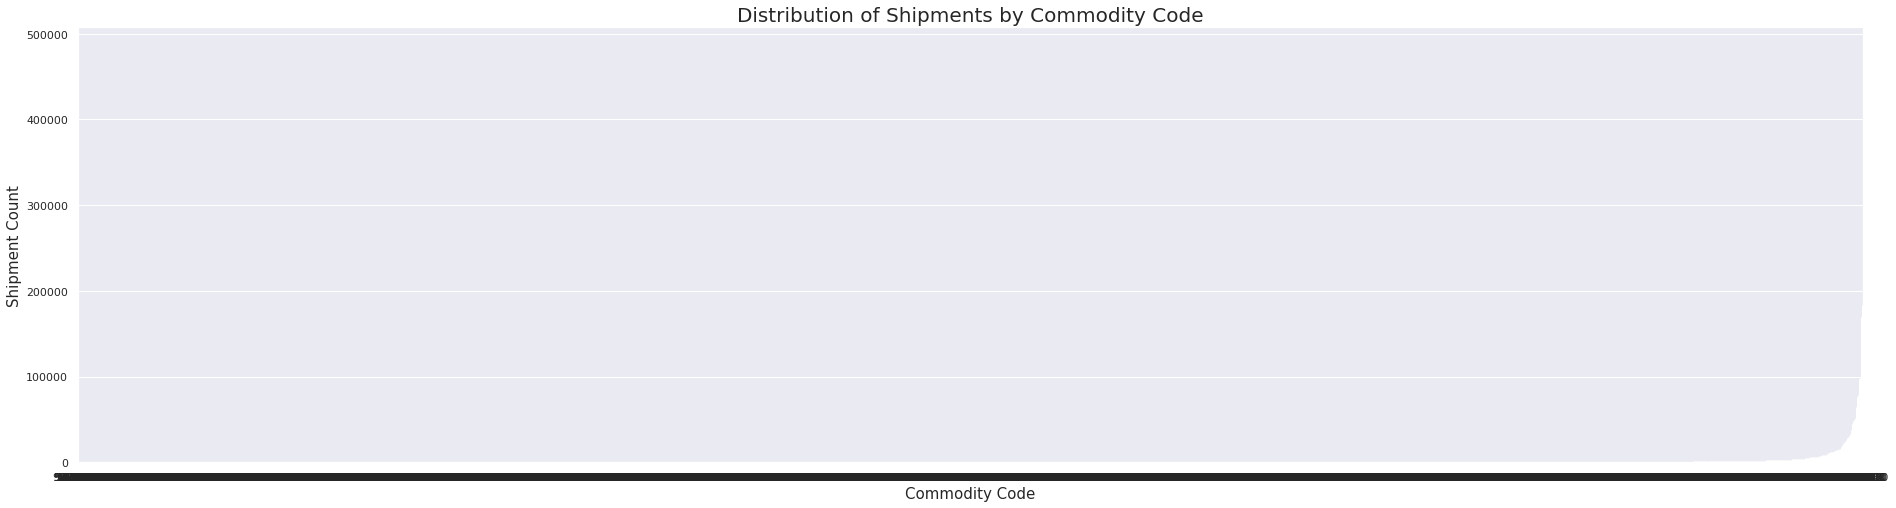

In [34]:
#plot the distribution of commodity code shipments
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(32,8)})

# function to group the bars and show similar heights in similar colors
# def colors_from_values(values, palette_name):
#     # normalize the values to range [0, 1]
#     normalized = (values - min(values)) / (max(values) - min(values))
#     # convert to indices
#     indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
#     # use the indices to get the colors
#     palette = sns.color_palette(palette_name, len(values))
#     return np.array(palette).take(indices, axis=0)

# ax = sns.barplot(data=df4, x="CMDT Code", y="B/L_No_count", palette=colors_from_values("B/L_No_count", "YlOrRd"))
ax = sns.barplot(data=df4, x="CMDT Code", y="B/L_No_count", palette=('Blues_d'), order=df4['CMDT Code'])
ax.axes.set_title('Distribution of Shipments by Commodity Code', fontsize = 20)
ax.set_xlabel('Commodity Code', fontsize = 15)
ax.set_ylabel('Shipment Count', fontsize = 15)
# for p in ax.patches:
#     ax.annotate(format(p.get_height(), '.0f'), 
#                    (p.get_x() + p.get_width() / 2., p.get_height()), 
#                    ha = 'center', va = 'center', 
#                    xytext = (0, 9),
#                    fontsize = 10,
#                    textcoords = 'offset points')

In [35]:
df4_top = df4.tail(50)

[Text(0, 0, '210050.0'),
 Text(0, 0, '701906.0'),
 Text(0, 0, '21.0'),
 Text(0, 0, '847102.0'),
 Text(0, 0, '990001.0'),
 Text(0, 0, '12.0'),
 Text(0, 0, '870024.0'),
 Text(0, 0, '940007.0'),
 Text(0, 0, '300504.0'),
 Text(0, 0, '700005.0'),
 Text(0, 0, '842823.0'),
 Text(0, 0, '630200.0'),
 Text(0, 0, '950000.0'),
 Text(0, 0, '871103.0'),
 Text(0, 0, '400011.0'),
 Text(0, 0, '831106.0'),
 Text(0, 0, '600002.0'),
 Text(0, 0, '830022.0'),
 Text(0, 0, '380600.0'),
 Text(0, 0, '950007.0'),
 Text(0, 0, '400026.0'),
 Text(0, 0, '290000.0'),
 Text(0, 0, '160001.0'),
 Text(0, 0, '831103.0'),
 Text(0, 0, '380036.0'),
 Text(0, 0, '390013.0'),
 Text(0, 0, '840021.0'),
 Text(0, 0, '360400.0'),
 Text(0, 0, '701306.0'),
 Text(0, 0, '820019.0'),
 Text(0, 0, '847100.0'),
 Text(0, 0, '210011.0'),
 Text(0, 0, '990006.0'),
 Text(0, 0, '847124.0'),
 Text(0, 0, '9.0'),
 Text(0, 0, '940435.0'),
 Text(0, 0, '990008.0'),
 Text(0, 0, '640001.0'),
 Text(0, 0, '940010.0'),
 Text(0, 0, '26.0'),
 Text(0, 0, '8541

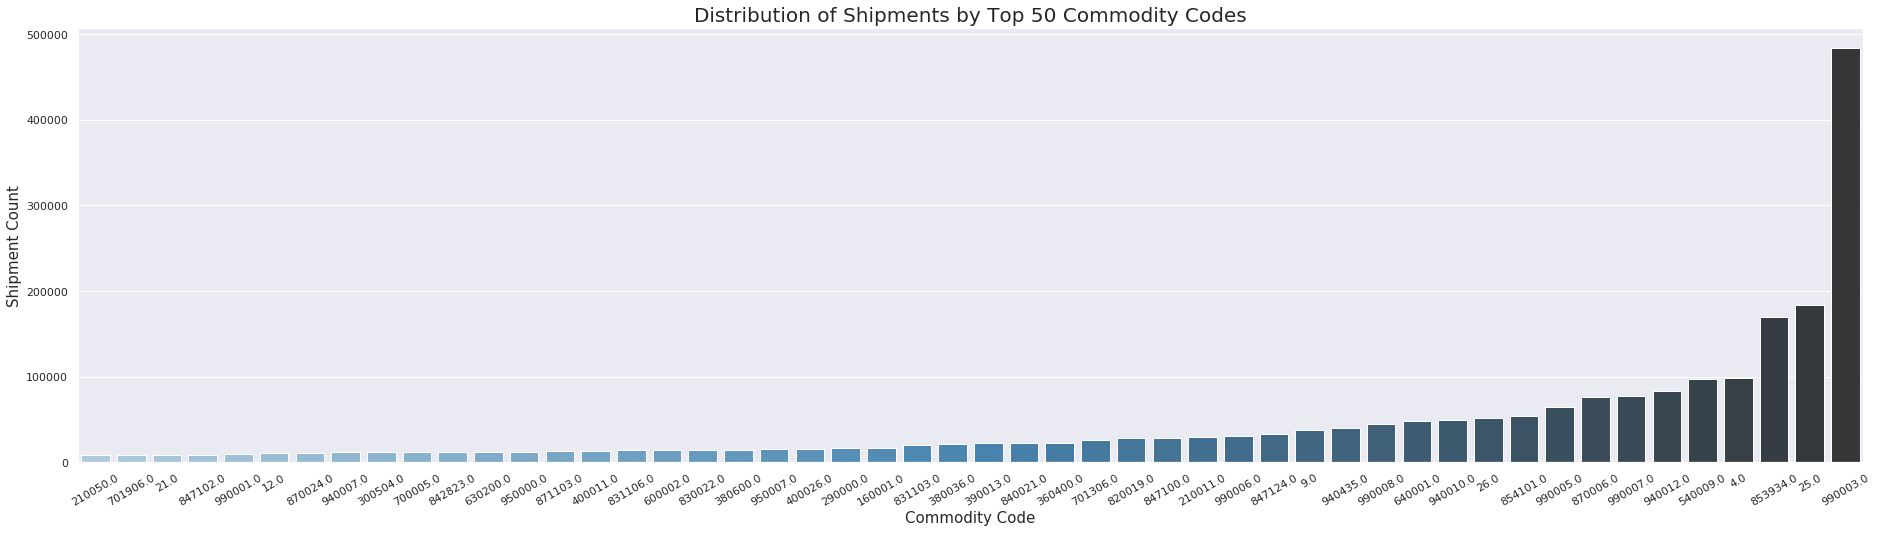

In [36]:
#plot the distribution of top 50 commodity code shipments
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(32,8)})


# ax = sns.barplot(data=df4, x="CMDT Code", y="B/L_No_count", palette=colors_from_values("B/L_No_count", "YlOrRd"))
ax = sns.barplot(data=df4_top, x="CMDT Code", y="B/L_No_count", palette=('Blues_d'), order=df4_top['CMDT Code'])
ax.axes.set_title('Distribution of Shipments by Top 50 Commodity Codes', fontsize = 20)
ax.set_xlabel('Commodity Code', fontsize = 15)
ax.set_ylabel('Shipment Count', fontsize = 15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

### What about the description field??

In [37]:
! pip install wordcloud

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [40]:
len(import_df_clean)

[########################################] | 100% Completed |  9.1s


2875681

In [43]:
import_df_clean2 = import_df_clean.dropna(subset=['Customs Description'])

In [44]:
len(import_df_clean2)

[########################################] | 100% Completed | 10.7s


2874433

[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  2.9s


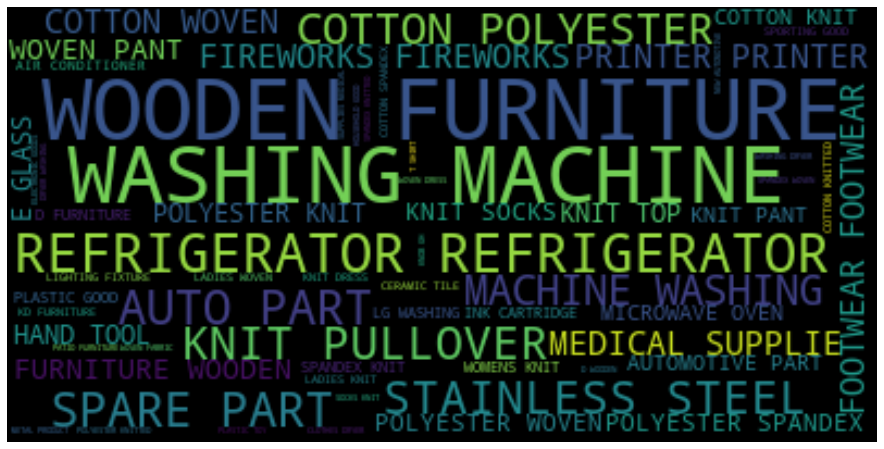

In [48]:
from wordcloud import WordCloud

wordcloud = WordCloud().generate(' '.join(import_df_clean2['Customs Description']))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [89]:
s5 = import_df_clean.groupby(['CMDT Code', 'CMDT'])["B/L No"].count().compute() # Do not call compute always. It will kill the notebook

[########################################] | 100% Completed |  9.4s
[########################################] | 100% Completed |  9.5s
[########################################] | 100% Completed |  9.6s
[########################################] | 100% Completed |  9.7s


In [91]:
s5

CMDT Code  CMDT                                                                              
0.0        FAK OR CARGO, NOS                                                                      2714
1.0        REFRIGERATED AND TEMPERATURE CONTROLLED CARGO, NOS                                      646
2.0        FREIGHT ALL KINDS, FAK                                                                  693
3.0        CARGO IN REFRIGERATION, NOS                                                             186
4.0        CONSOLIDATED OR MIXED LOADS OF COMMODITIES,NOS EXCEPT SPECIAL EQ AND DG/HAZ GOODS.    98146
                                                                                                 ...  
960126.0   RICE BOX, NOS                                                                             3
960305.0   TRAPS; NOS                                                                               24
960600.0   PRESS FASTENING, VELCRO, NOS                                           

In [92]:
df5 = pd.DataFrame({'CMDT Code':s5.index, 'CMDT':s5.values, 'B/L_No_count':s5.values}).sort_values("B/L_No_count").reset_index(drop=True)
df5

AttributeError: 'MultiIndex' object has no attribute '_data'

In [101]:
df5 = pd.DataFrame(s5).sort_values('B/L No').reset_index(drop=False)
df5

,CMDT Code,CMDT,B/L No
0,980028.0,PROMOTIONAL ITEMS(WITH FOB VALUE PER PIECE UND...,3
1,520008.0,"THREAD OR YARD OF COTTON, NOS",3
2,530700.0,"JUTE YARN, NOS",3
3,531001.0,"COTTON WASTE, CUTTING SCRAP, GREY CLOTH, WIPIN...",3
4,550002.0,"POLYESTER FIBERS, POLYESTER FILAMENT YARN; NOS",3
...,...,...,...
2277,540009.0,"GARMENTS, NOS;",97433
2278,4.0,"CONSOLIDATED OR MIXED LOADS OF COMMODITIES,NOS...",98146
2279,853934.0,"ELECTRONIC GOODS AND PARTS, NOS;",169778
2280,25.0,STRAIGHT LOADS OF COMMODITIES NOS EXCLUDING TE...,183598


In [111]:
commodities_master.head(10)

[                                        ] | 0% Completed |  0.0s

/usr/local/lib/python3.8/dist-packages/dask/core.py:121: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.8s
[########################################] | 100% Completed |  0.8s


,REP CMDT,CMDT Code,CMDT - Commodity
0,0,0,"FAK OR CARGO, NOS"
1,0,1,"REFRIGERATED AND TEMPERATURE CONTROLLED CARGO,..."
2,0,2,"FREIGHT ALL KINDS, FAK"
3,0,3,"CARGO IN REFRIGERATION, NOS"
4,0,4,"CONSOLIDATED OR MIXED LOADS OF COMMODITIES,NOS..."
5,0,5,STRAIGHT OR MIXED COMMODITIES NOS (BUT EXCLUDI...
6,0,7,"FREIGHT ALL KINDS(SINGLE COMMODITY LOAD, STRAI..."
7,0,8,"FREIGHT ALL KINDS(EXCLUDING GARMENTS, NOS)"
8,0,9,STRAIGHT OR MIXED LOADS OF COMMODITIES NOS INC...
9,0,12,"GDSM EXCLUDING TEXILE, NON-HAZARDOUS, IN MIXED..."


In [109]:
commodities_master_df = pd.DataFrame(commodities_master).reset_index(drop=False)


[                                        ] | 0% Completed |  0.1s

/usr/local/lib/python3.8/dist-packages/dask/core.py:121: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.1s

/usr/local/lib/python3.8/dist-packages/dask/core.py:121: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s


In [110]:
commodities_master_df.head()

,index,0
0,0,REP CMDT
1,1,CMDT Code
2,2,CMDT - Commodity


In [96]:
# Join the shipping dataframe with the master file

result = pd.concat([commodities_master_df,df5], axis = 1)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:2618: RuntimeWarning: '<' not supported between instances of 'tuple' and 'int', sort order is undefined for incomparable objects
  return Index.union(this, other, sort=sort).astype(object, copy=False)


In [97]:
result

,0,B/L No
0,REP CMDT,NaN
1,CMDT Code,NaN
2,CMDT - Commodity,NaN
"(980028.0, PROMOTIONAL ITEMS(WITH FOB VALUE PER PIECE UNDER USD5.00))",NaN,3.0
"(520008.0, THREAD OR YARD OF COTTON, NOS)",NaN,3.0
...,...,...
"(540009.0, GARMENTS, NOS;)",NaN,97433.0
"(4.0, CONSOLIDATED OR MIXED LOADS OF COMMODITIES,NOS EXCEPT SPECIAL EQ AND DG/HAZ GOODS.)",NaN,98146.0
"(853934.0, ELECTRONIC GOODS AND PARTS, NOS;)",NaN,169778.0
"(25.0, STRAIGHT LOADS OF COMMODITIES NOS EXCLUDING TEXTILES AND GARMENTS)",NaN,183598.0
